In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from Helper.K_folds import build_folds, kth_fold
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sns
from xgboost import XGBClassifier


In [ ]:
# To check the Python executable path 

#import sys
#print(sys.executable)

C:\Users\Spike\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe


In [24]:
#
# Read in data here
#

data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Dropping useless columns
data.drop(columns=["id"],inplace=True)
test_data.drop(columns=["id"], inplace=True) 


In [16]:
# we can apply differnet formulas for expected_max_hr depending on gender

data["Sex"].value_counts()

# Exploring ST_depression values
data["ST depression"].describe()


# Exploring Heart Rate
data["Max HR"].describe()

# Exploring Cholesterol
data["Cholesterol"].describe()



# Overall
data.head(15)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence
5,38,1,4,138,283,0,0,147,1,1.6,2,2,7,Presence
6,59,1,4,130,246,0,2,152,0,0.8,2,2,3,Presence
7,60,0,3,120,245,0,0,151,0,1.2,1,0,3,Absence
8,48,0,4,140,212,0,2,125,0,0.0,1,0,3,Absence
9,44,0,4,150,197,0,0,150,0,0.0,2,0,3,Absence


In [18]:
# HR ratio seems to be a good feature, potentially explore if there is any other way to improve (optimize 220 threshold?) 
# could also explore log since this looks slightly right skewed

# Female: HR max = 206 - 0.88 * Age
# Male: 220 - Age
data["expected_max_hr"] = 220 - data["Age"]
test_data["expected_max_hr"] = 220 - test_data["Age"]

data["expected_max_hr"] = np.where(data["Sex"] == 0, 206 - 0.88 * data["Age"], 220 - data["Age"])
test_data["expected_max_hr"] = np.where(test_data["Sex"] == 0, 206 - 0.88 * test_data["Age"], 220 - test_data["Age"])


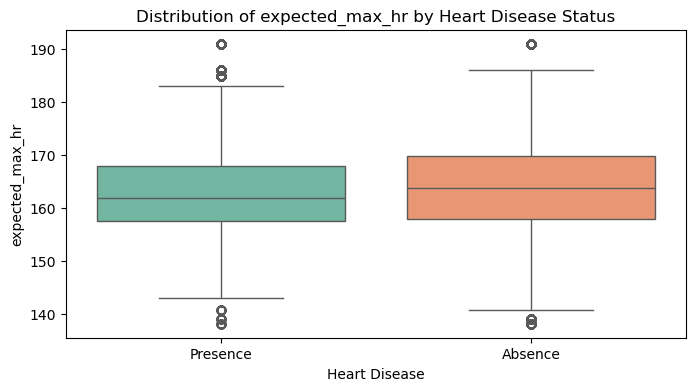

In [9]:
# Plotting max_hr
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x="Heart Disease", y="expected_max_hr", hue='Heart Disease', palette='Set2', legend=False)
plt.title(f'Distribution of expected_max_hr by Heart Disease Status')
plt.show()

In [6]:
# # Exercise Angina x Max HR new feature
# # Since exercise angina is binary, we can simply 

# # Age-adjusted HR ratio (if not already created)
# # 1 is Male
# # 0 is Female


# # Low HR flags
# data["low_hr_ratio"] = (data["hr_ratio"] < 0.85).astype(int)    # intuitively, this threshold can be tweaked
# test_data["low_hr_ratio"] = (test_data["hr_ratio"] < 0.85).astype(int)

# # Interaction
# data["exang_low_hr"] = data["Exercise angina"] & data["low_hr_ratio"]
# test_data["exang_low_hr"] = test_data["Exercise angina"] & test_data["low_hr_ratio"]


In [5]:
# Sweep the base value for expected_max_hr and track its coefficient
# Note: using LogisticRegression (classification). Swap to LinearRegression if you prefer.
from sklearn.preprocessing import StandardScaler

base_values = range(100, 260)  # adjust range as needed
results = []

for base in base_values:
    temp = data.copy()

    temp["expected_max_hr"] = base - temp["Age"]
    temp["hr_ratio"] = temp["Max HR"] / temp["expected_max_hr"]
    temp["low_hr_ratio"] = (temp["hr_ratio"] < 0.85).astype(int)
    temp["exang_low_hr"] = (temp["Exercise angina"] & temp["low_hr_ratio"]).astype(int)

    train_df, val_df = kth_fold(temp, target_col="Heart Disease", k=20, fold_index=5)

    target_col = "Heart Disease"
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]

    num_cols = X_train.select_dtypes(include=["number"]).columns
    cat_cols = X_train.select_dtypes(exclude=["number"]).columns

    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ]
    )

    model = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("clf", LogisticRegression(
                penalty="l2",
                solver="lbfgs",
                max_iter=2000,
                n_jobs=-1
            )),
        ]
    )

    model.fit(X_train, y_train)

    feature_names = model.named_steps["preprocess"].get_feature_names_out()
    coefs = model.named_steps["clf"].coef_.ravel()
    coef_map = dict(zip(feature_names, coefs))

    results.append({"base": base, "expected_max_hr_coef": coef_map.get("num__expected_max_hr", np.nan)})

results_df = pd.DataFrame(results).dropna()

# Plot coefficient vs base
plt.figure(figsize=(8, 4))
sns.lineplot(data=results_df, x="base", y="expected_max_hr_coef")
best_row = results_df.loc[results_df["expected_max_hr_coef"].idxmin()]
plt.axvline(best_row["base"], color="red", linestyle="--")
plt.title("Expected Max HR Coefficient vs Base Value")
plt.xlabel("Base value in (base - Age)")
plt.ylabel("Logistic Regression Coefficient (standardized)")
plt.show()

print("Best base:", int(best_row["base"]), "coef:", float(best_row["expected_max_hr_coef"]))


KeyboardInterrupt: 

In [ ]:
# Hypertension flag
data["hypertension"] = (data["BP"] >= 130).astype(int) # explore this threshold, visualize from EDA
test_data["hypertension"] = (test_data["BP"] >= 130).astype(int)

data["exang_hypertension"] = data["Exercise angina"] & data["hypertension"]
test_data["exang_hypertension"] = test_data["Exercise angina"] & test_data["hypertension"]

# Creating new interaction term (where we weight each level of the categorical variables by the frequency in which they appear in the dataset)

NUMS = ["Thallium","Sex","Exercise angina","Slope of ST","Number of vessels fluro"]

# Compute frequencies from ALL data (train + orig + test)
for cat in NUMS:
    freq = pd.concat([data[cat], test_data[cat]]).value_counts(normalize=True)
    for df in [data, test_data]:
        df[f'FREQ_{cat}'] = df[cat].map(freq).fillna(0).astype('float32')


# Creating category features
# ST_Depression >= 1
# ST_Depression < 1
data["ST_depression_flag"] = np.where(data["ST depression"] >= 1, 1, 0)
test_data["ST_depression_flag"] = np.where(test_data["ST depression"] >= 1, 1, 0)

# High Cholesterol Cateogorical Variable
data["high_cholesterol"] = np.where(data["Cholesterol"] >= 240, 1, 0)
test_data["high_cholesterol"] = np.where(test_data["Cholesterol"] >= 240, 1, 0)


# Age**2 variable, since age seems to have a non-linear relationship with heart disease
data["Age_squared"] = data["Age"] ** 2
test_data["Age_squared"] = test_data["Age"] ** 2


# Explicity calling the CAT variables as variables 
# I suspect that the model is not fully capturing the non-linear relationship between the categorical variables and the target, so this is an attempt to explicitly call out these variables as features.
data["Sex"] = data["Sex"].astype("category")
test_data["Sex"] = test_data["Sex"].astype("category")

data["Exercise angina"] = data["Exercise angina"].astype("category")
test_data["Exercise angina"] = test_data["Exercise angina"].astype("category")

data["FBS over 120"] = data["FBS over 120"].astype("category")
test_data["FBS over 120"] = test_data["FBS over 120"].astype("category")

data["Number of vessels fluro"] = data["Number of vessels fluro"].astype("category")
test_data["Number of vessels fluro"] = test_data["Number of vessels fluro"].astype("category")

data["ST_depression_flag"] = data["ST_depression_flag"].astype("category")
test_data["ST_depression_flag"] = test_data["ST_depression_flag"].astype("category")

data["high_cholesterol"] = data["high_cholesterol"].astype("category")  
test_data["high_cholesterol"] = test_data["high_cholesterol"].astype("category")

data["Thallium"] = data["Thallium"].astype("category")
test_data["Thallium"] = test_data["Thallium"].astype("category")


In [23]:
data.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,...,hypertension,exang_hypertension,FREQ_Thallium,FREQ_Sex,FREQ_Exercise angina,FREQ_Slope of ST,FREQ_Number of vessels fluro,ST_depression_flag,high_cholesterol,Age_squared
0,58,1,4,152,239,0,0,158,1,3.6,...,1,1,0.391757,0.715209,0.274004,0.407499,0.086391,1,0,3364
1,52,1,1,125,325,0,2,171,0,0.0,...,0,0,0.590871,0.715209,0.725996,0.567792,0.707054,0,1,2704
2,56,0,2,160,188,0,2,151,0,0.0,...,1,0,0.590871,0.284791,0.725996,0.567792,0.707054,0,0,3136
3,44,0,3,134,229,0,2,150,0,1.0,...,1,0,0.590871,0.284791,0.725996,0.407499,0.707054,1,0,1936
4,58,1,4,140,234,0,2,125,1,3.8,...,1,1,0.590871,0.715209,0.274004,0.407499,0.036416,1,0,3364


# Plots of newly engineered features

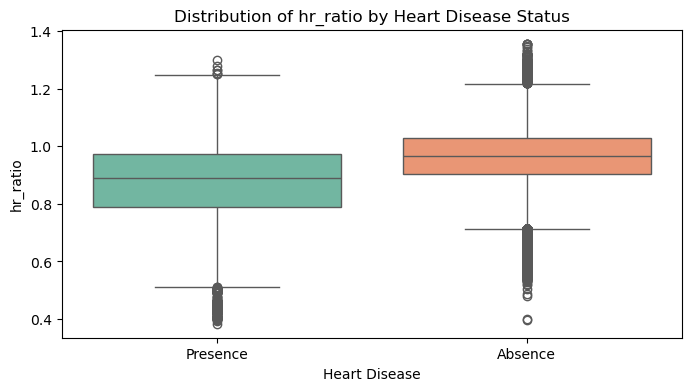

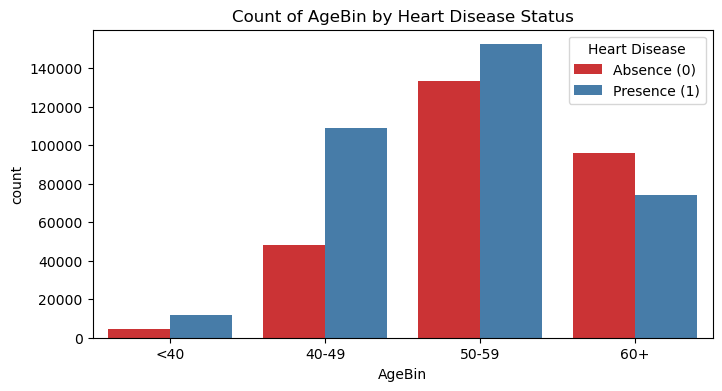

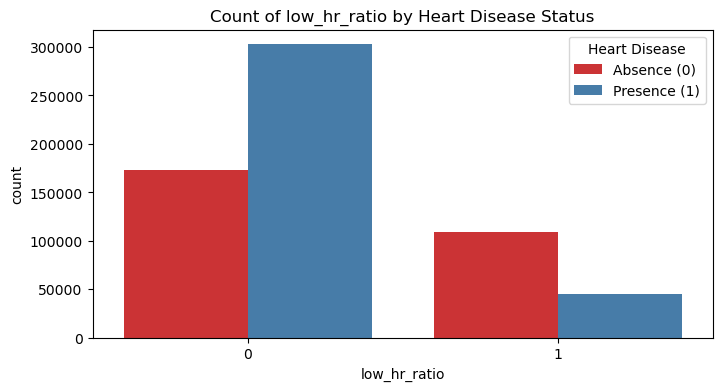

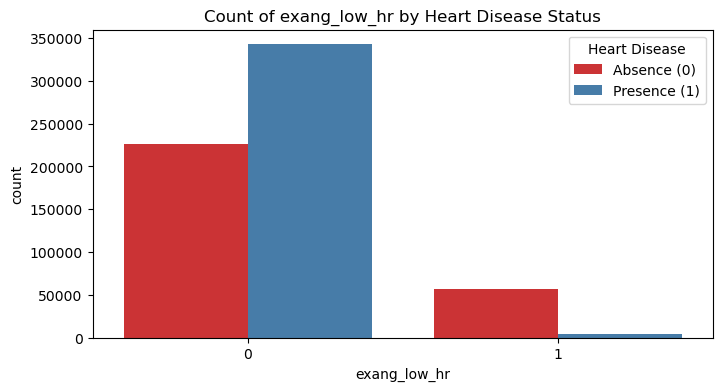

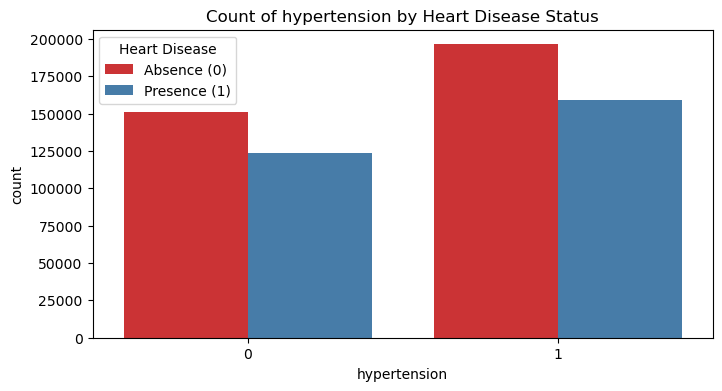

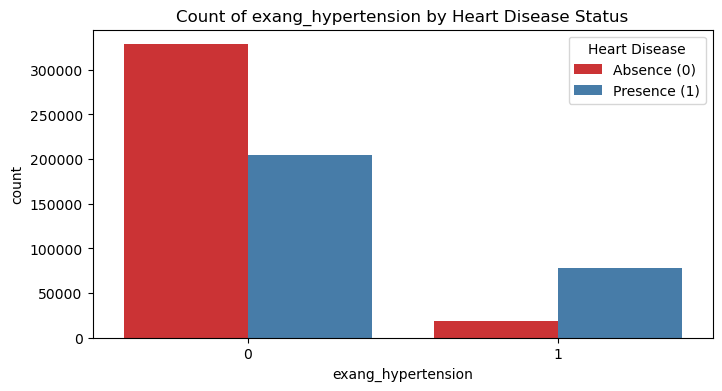

In [ ]:
target= "Heart Disease"
numerical_cols = ["hr_ratio"]
categorical_cols = ["AgeBin",  "exang_low_hr", "hypertension", "exang_hypertension"]

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data, x=target, y=col, hue=target, palette='Set2', legend=False)
    plt.title(f'Distribution of {col} by Heart Disease Status')
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col, hue=target, palette='Set1')
    plt.title(f'Count of {col} by Heart Disease Status')
    plt.legend(title='Heart Disease', labels=['Absence (0)', 'Presence (1)'])
    plt.show()

# TRAINING MODEL
List of models trained (update as we go along)


1) Random Forest (Public Score = 0.05490 - very clear overfitting duh)
2) Ridge Regression Model
3) XGBoost (5000 esitmators - 0.88377)
            (50000 estimators - 0.88322)
4) d

In [35]:
# Get the k-th fold
train_df, val_df = kth_fold(data, target_col="Heart Disease", k=20, fold_index=5)

target_col = "Heart Disease"
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

# Split columns by type
num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(exclude=["number"]).columns

# Preprocess: one-hot encode categoricals only
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Model pipeline
model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42)),
    ]
)

# Train + evaluate
model.fit(X_train, y_train)
preds = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, preds))
print(classification_report(y_val, preds))

Accuracy: 0.8789206349206349
              precision    recall  f1-score   support

     Absence       0.89      0.89      0.89     17377
    Presence       0.87      0.86      0.86     14123

    accuracy                           0.88     31500
   macro avg       0.88      0.88      0.88     31500
weighted avg       0.88      0.88      0.88     31500



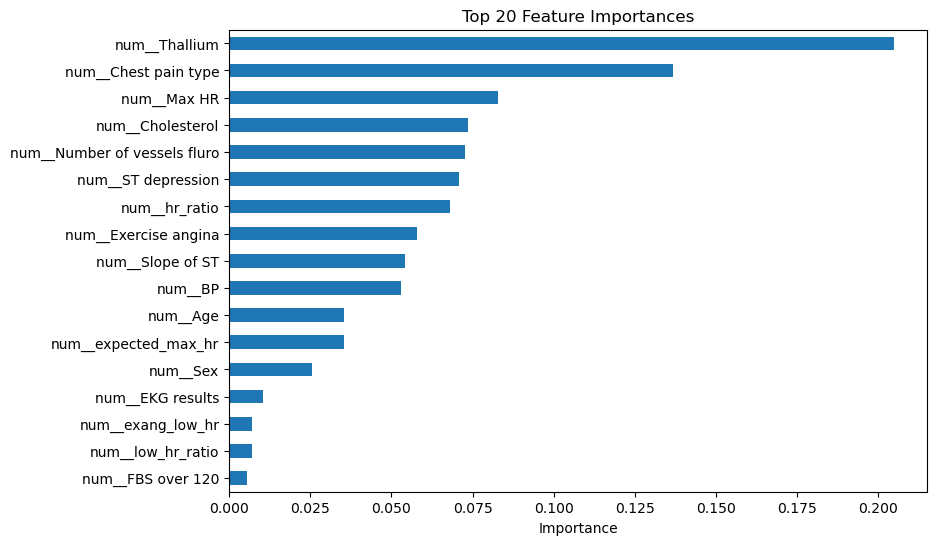

In [36]:

# After model.fit(...)
rf = model.named_steps["clf"]
pre = model.named_steps["preprocess"]

# Feature names after one-hot encoding
feature_names = pre.get_feature_names_out()

# Importance series
feat_imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot top N
top_n = 20
plt.figure(figsize=(9, 6))
feat_imp.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.show()

When we use (x data points) we have an accuracy matrix of ()


1) 20 000 

Accuracy: 0.87725
              precision    recall  f1-score   support

     Absence       0.88      0.90      0.89      2198
    Presence       0.87      0.85      0.86      1802
    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000


2) 200,000
   
Accuracy: 0.882975
              precision    recall  f1-score   support

     Absence       0.89      0.90      0.89     22081
    Presence       0.87      0.86      0.87     17919
    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88     40000


3) 400,000 (likely some form of overfitting)
   
Accuracy: 0.8826125
              precision    recall  f1-score   support

     Absence       0.89      0.90      0.89     44138
    Presence       0.87      0.86      0.87     35862
    accuracy                           0.88     80000
   macro avg       0.88      0.88      0.88     80000
weighted avg       0.88      0.88      0.88     80000


Top Features found:
1) Thallium
2) Chest pain type
3) Max HR
4) Number of vessels fluro
5) ST depression
6) hr ratio
7) Cholesterol
8) Slope of ST
9) Exercise angina
10) BP
11) expected_max_hr
12) Age

# RIDGE LOGISTIC REGRESSION MODEL
Full Features


In [17]:

# Get the k-th fold
train_df, val_df = kth_fold(data, target_col="Heart Disease", k=20, fold_index=5)

# Prepare data
target_col = "Heart Disease"
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

# Split columns by type
num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(exclude=["number"]).columns

# Preprocess: one-hot encode categoricals only
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Base pipeline
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            max_iter=2000,
            n_jobs=-1
        )),
    ]
)

# Grid of C values to search (inverse of lambda)
param_grid = {"clf__C": [0.001, 0.01, 0.1, 1, 10, 100]}

# GridSearch with 5-fold cross-validation using AUC
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# Fit on training data
grid.fit(X_train, y_train)

# Best regularization
print("Best C (inverse of lambda):", grid.best_params_["clf__C"])
print("Best cross-validated AUC:", grid.best_score_)

# Evaluate on validation set
best_model = grid.best_estimator_
pred_probs = best_model.predict_proba(X_val)[:, 1]  # probability for positive class
val_auc = roc_auc_score(y_val, pred_probs)
print("Validation AUC:", val_auc)

# After model fitting
clf = best_model.named_steps["clf"]
pre = best_model.named_steps["preprocess"]

feature_names = pre.get_feature_names_out()
coefs = clf.coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

print(coef_df.sort_values("abs_coef", ascending=False).head(30))


Best C (inverse of lambda): 10
Best cross-validated AUC: 0.9508099508637073
Validation AUC: 0.9504509745227481
                              feature      coef  abs_coef
20  num__FREQ_Number of vessels fluro -1.625431  1.625431
19              num__FREQ_Slope of ST  1.431970  1.431970
10                   num__Slope of ST  1.076298  1.076298
1                            num__Sex  1.043055  1.043055
2                num__Chest pain type  1.034521  1.034521
8                num__Exercise angina  1.007879  1.007879
12                      num__Thallium  0.495370  0.495370
18          num__FREQ_Exercise angina -0.490383  0.490383
9                  num__ST depression  0.488064  0.488064
17                      num__FREQ_Sex  0.435286  0.435286
11       num__Number of vessels fluro  0.321921  0.321921
6                    num__EKG results  0.215980  0.215980
16                 num__FREQ_Thallium  0.050219  0.050219
5                   num__FBS over 120 -0.044914  0.044914
7                  

# RIDGE REGRESSION MODEL
Selected Features only (Choosing top)

# XG Boost


In [20]:
data["Heart Disease"] = (
    data["Heart Disease"]
      .astype(str).str.strip()
      .map({"Absence": 0, "Presence": 1})
      .astype("int8")
)

X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"].values


In [ ]:


oof = np.zeros(len(data), dtype=np.float32)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = XGBClassifier(
        n_estimators=5000,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=10,
        gamma=0.1,
        reg_alpha=0.0,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        enable_categorical=True,
        early_stopping_rounds=100
    )

 


    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    oof[val_idx] = model.predict_proba(X_val)[:, 1]

oof_auc = roc_auc_score(y, oof)
print("OOF AUC:", oof_auc)


Fold 1
[0]	validation_0-auc:0.90478
[100]	validation_0-auc:0.95287
[200]	validation_0-auc:0.95433
[300]	validation_0-auc:0.95474
[400]	validation_0-auc:0.95500
[500]	validation_0-auc:0.95526
[600]	validation_0-auc:0.95545
[700]	validation_0-auc:0.95558
[800]	validation_0-auc:0.95565
[900]	validation_0-auc:0.95570
[1000]	validation_0-auc:0.95575
[1100]	validation_0-auc:0.95578
[1200]	validation_0-auc:0.95581
[1300]	validation_0-auc:0.95583
[1400]	validation_0-auc:0.95584
[1500]	validation_0-auc:0.95586
[1600]	validation_0-auc:0.95587
[1700]	validation_0-auc:0.95587
[1800]	validation_0-auc:0.95588
[1900]	validation_0-auc:0.95588
[1945]	validation_0-auc:0.95588
Fold 2
[0]	validation_0-auc:0.90439
[100]	validation_0-auc:0.95184
[200]	validation_0-auc:0.95338
[300]	validation_0-auc:0.95373
[400]	validation_0-auc:0.95403
[500]	validation_0-auc:0.95428
[600]	validation_0-auc:0.95446
[700]	validation_0-auc:0.95460
[800]	validation_0-auc:0.95468
[900]	validation_0-auc:0.95473
[1000]	validation_

# TO help visualise

In [ ]:
lambda_grid = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

kf = KFold(n_splits=10, shuffle=True, random_state=42)

lambda_results = {}  # store OOF AUC per lambda

for reg_lambda in lambda_grid:
    print(f"\n===== Testing reg_lambda = {reg_lambda} =====")

    oof = np.zeros(len(data), dtype=np.float32)
    all_fold_auc = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = XGBClassifier(
            n_estimators=5000,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=10,
            gamma=0.1,
            reg_alpha=0.0,
            reg_lambda=reg_lambda,   # 👈 this is now tuned
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            n_jobs=-1,
            random_state=42,
            enable_categorical=True,
            early_stopping_rounds=100
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        oof[val_idx] = model.predict_proba(X_val)[:, 1]

        evals = model.evals_result()
        all_fold_auc.append(evals["validation_0"]["auc"])

    oof_auc = roc_auc_score(y, oof)
    lambda_results[reg_lambda] = oof_auc

    print(f"OOF AUC (reg_lambda={reg_lambda}): {oof_auc:.5f}")



===== Testing reg_lambda = 0.1 =====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
OOF AUC (reg_lambda=0.1): 0.95548

===== Testing reg_lambda = 0.5 =====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
OOF AUC (reg_lambda=0.5): 0.95548

===== Testing reg_lambda = 1.0 =====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
OOF AUC (reg_lambda=1.0): 0.95548

===== Testing reg_lambda = 2.0 =====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
OOF AUC (reg_lambda=2.0): 0.95547

===== Testing reg_lambda = 5.0 =====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
OOF AUC (reg_lambda=5.0): 0.95547

===== Testing reg_lambda = 10.0 =====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


KeyboardInterrupt: 

In [ ]:
print("\n===== Lambda Comparison =====")
for lam, auc in lambda_results.items():
    print(f"reg_lambda={lam:<5} | OOF AUC={auc:.5f}")

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(list(lambda_results.keys()), list(lambda_results.values()), marker="o")
plt.xscale("log")
plt.xlabel("reg_lambda (log scale)")
plt.ylabel("OOF AUC")
plt.title("Effect of L2 Regularization (reg_lambda)")
plt.grid(True)
plt.show()

In [21]:
# IF XGBoost model's OOF AUC is good, proceed to train on full data and predict on test set

best_model = XGBClassifier(
        n_estimators=50000,
        max_depth=3,
        learning_rate=0.001,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=10,
        gamma=0.1,
        reg_alpha=0.0,
        reg_lambda=10,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        enable_categorical=True
    )
best_model.fit(X, y)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'auc'


In [22]:
# Submission
# Predict on test data
test_preds = best_model.predict(test_data)

# Build submission using sample file for correct columns/order
submission = pd.read_csv("sample_submission.csv")
target_col = "Heart Disease"
submission[target_col] = test_preds

submission.to_csv("submission.csv", index=False)


In [46]:
#test_data.head()
data.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,...,Thallium,Heart Disease,expected_max_hr,hypertension,exang_hypertension,FREQ_Thallium,FREQ_Sex,FREQ_Exercise angina,FREQ_Slope of ST,FREQ_Number of vessels fluro
0,58,1,4,152,239,0,0,158,1,3.6,...,7,1,162.00,1,1,0.391757,0.715209,0.274004,0.407499,0.086391
1,52,1,1,125,325,0,2,171,0,0.0,...,3,0,168.00,0,0,0.590871,0.715209,0.725996,0.567792,0.707054
2,56,0,2,160,188,0,2,151,0,0.0,...,3,0,156.72,1,0,0.590871,0.284791,0.725996,0.567792,0.707054
3,44,0,3,134,229,0,2,150,0,1.0,...,3,0,167.28,1,0,0.590871,0.284791,0.725996,0.407499,0.707054
4,58,1,4,140,234,0,2,125,1,3.8,...,3,1,162.00,1,1,0.590871,0.715209,0.274004,0.407499,0.036416
